# Statistická analýza, příprava dat

## Portland Housing Prices/Sales Jul 2020 - Jul 2021
- https://www.kaggle.com/datasets/threnjen/portland-housing-prices-sales-jul-2020-jul-2021
- 348 columns
- 25681 records

Pro tento příklad budeme používat podmnožinu s tohoto souboru.
!!! Vytvořený subset nemusí statisticky odpovídat původnímu souboru

## Sub dataset
- Data  = struktura s vyplněnými daty
- m 	= počet řádků = 100
- x’s = vstupní proměnná / features
- y’s = výstupní promměná / target
- (x, y) = jeden řádek z training dataset
- x(2) = (4, 5, 3374, 85)
- y(2) = 1 050 000

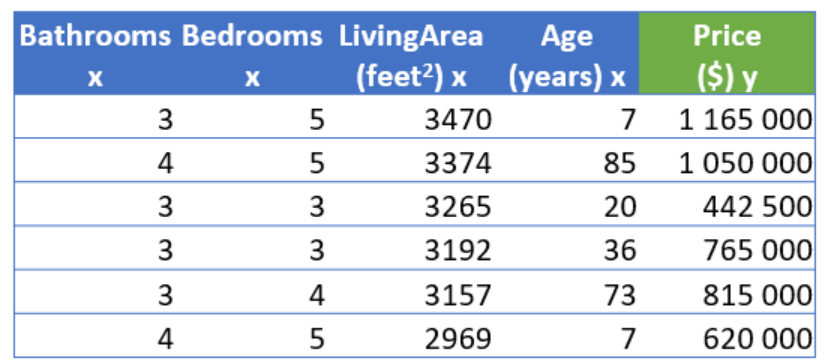

# Úkol
- Vytvořte regresní lineání model z parametrů, které jste vybrali minulé cvičení
- Data před zpracováním standardizujte
- Model vytvořte ručně
- Model vytvořte pomocí scikit-learn

# Načtení dat

In [145]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from sklearn.model_selection import train_test_split
import random
from sklearn.metrics import mean_squared_error, r2_score
import plotly.graph_objects as go

In [146]:
data = pd.read_csv ("..\\dataset\\portland_filtered.csv",  sep=';')

In [147]:
data=data.dropna()

In [148]:
data['livingArea_STD'] = (data['livingArea'] - data['livingArea'].mean()) / data['livingArea'].std()
data['bathrooms_STD'] = (data['bathrooms'] - data['bathrooms'].mean()) / data['bathrooms'].std()
data['bedrooms_STD'] = (data['bedrooms'] - data['bedrooms'].mean()) / data['bedrooms'].std()
data['age_STD'] = (data['age'] - data['age'].mean()) / data['age'].std()
data['price_STD'] = (data['price'] - data['price'].mean()) / data['price'].std()

# Lineání model bez pomocí knihoven
- Vytvořte si ručně model lineární regrese bez pomoci externích knihoven
- Vypište jeho parametry
- Vypiše jeho skóre pro trénovací a validační data
- Vykreslete graf historie učení
- Vizualizujte model

In [149]:
X = pd.DataFrame(np.c_[data['livingArea_STD'], data['bathrooms_STD'], data['bedrooms_STD'], data['age_STD']],
                 columns=['livingArea_STD', 'bathrooms_STD', 'bedrooms_STD', 'age_STD']).to_numpy()

Y = data['price_STD'].to_numpy()

In [150]:
def split_dataset (X, Y, train_ratio = 0.75, validation_ratio = 0.15, test_ratio = 0.10):
    """ Slitting the dataset into training, validation and testing subset
        X - explanatory variables
        Y - explained variables

        train_ratio      - training data ratio
        validation_ratio - validation data ratio
        test_ratio       - ratio of test data

    """
    assert(train_ratio + validation_ratio + test_ratio == 1.0)

    # train nyní tvoří 75 % celého souboru dat
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=1 - train_ratio)

    # test je nyní 10 % původního souboru dat
    # nyní představuje 15 % původního souboru dat
    X_val, X_test, Y_val, Y_test = train_test_split(X_test, Y_test, test_size=test_ratio/(test_ratio + validation_ratio)) 
    return X_train, Y_train, X_val, Y_val, X_test, Y_test

In [151]:
# kontrola velikosti data subsets
X_train, Y_train, X_val, Y_val, X_test, Y_test = split_dataset(X, Y)
print (X_train.shape, Y_train.shape)
print (X_val.shape, Y_val.shape)
print (X_test.shape, Y_test.shape)

(75, 4) (75,)
(15, 4) (15,)
(10, 4) (10,)


In [152]:
x_label, y_label, z_label = "Living Area (m²)", "Bedrooms", "Price"
X1 = X_train[:, 0]  # 1. sloupec
X2 = X_train[:, 1]  # 2. sloupec
Y = Y_train  # Cílová proměnná
    
# Vytvoření 3D scatter plotu
fig = go.Figure()

# Scatter plot - body dat
fig.add_trace(go.Scatter3d(
        x=X1, y=X2, z=Y,
        mode='markers',
        marker=dict(size=5, color=Y, colorscale='Viridis', opacity=0.8),
        name="Data"
))
fig.show()

In [153]:
def initialize(dim):
    """ Initial linear model parameter settings - bias and weights
    """
    bias=random.random()
    weights=np.random.rand(dim)
    return bias, weights

In [154]:
def print_model_params(bias, weights):
    """Printing the current model parameters
    """
    print ("Model parameters\n================")
    print(f"Bias: {bias}")
    print (f"Weights: {weights}")  

In [155]:
bias, weights=initialize(X.shape[1])
print_model_params(bias, weights)

Model parameters
Bias: 0.25395300090319495
Weights: [0.74167627 0.46298357 0.74646351 0.8672532 ]


In [156]:
def predict(X, bias, weights):
    """ Based on the model parameters (bias and weights), the function calculates the output values Y from the input values X
        X - input numpy matrix
        bias - model parameter b
        weights - array of weights

        Returns matrix of predicted values Y
    """
    return bias + np.dot(X, weights)

In [157]:
# vyzkoušení predikce Y hodnot na trénovací množině
print ("Predicted values\n================")
Y_predicted = predict(X_train, bias, weights)
Y_predicted[0:10]

Predicted values


array([ 1.02296058, -0.28384519,  0.689076  , -2.13606599,  1.23232934,
       -0.21223281, -1.41837588, -0.64221626,  1.98234237, -2.0015395 ])

In [158]:
def update_weights(X, Y, Y_predicted, bias_0, weights_0, learning_rate):
    """ The function adjusts the model parameters bias and weights

        X - input values
        Y - correct output values
        Y_predicted - predicted values
        bias_0 - current value of bias
        weights_0 - current values of weights
        learning_rate - learning rate alpha

    """

    # výpočet parciálních derivací
    delta_bias = (np.sum(Y_predicted - Y))/len(Y)
    delta_weights = (np.dot((Y_predicted - Y),X))/len(Y)

    # výpočet úpravy parametrů modelu
    bias_1 = bias_0 - learning_rate * delta_bias
    weights_1 = weights_0 - learning_rate * delta_weights
    return bias_1, weights_1

In [159]:
def run_gradient_descent(X, Y, learning_rate, num_iterations):
    """ Algoritmus gradient descent 
        X - input data
        Y - output data
        learning_rate - learning rate alpha
        num_iteration - number of iteration    

        gd_iterations_df - history of learning
        bias             - bias parameter
        weights          - weights parameter
    """
    # inicializace parametrů modelu
    bias, weights=initialize(X.shape[1])
    iter_num=0

    # ukladání postupu učení do dataFrame
    gd_iterations_df=pd.DataFrame(columns=['iteration','cost'])
    result_idx=0
    
    for each_iter in range(num_iterations):
        # kontrolní zobrazení skóre
        Y_predicted = predict(X, bias, weights)
        this_cost=get_cost(Y, Y_predicted)

        # vylepšení parametrů
        prev_bias=bias
        prev_weights=weights
        bias, weights = update_weights(X, Y, Y_predicted, prev_bias, prev_weights, learning_rate)

        # uložení každé 10. iterace do historie učen
        if(iter_num % 10==0):
            gd_iterations_df.loc[result_idx]=[iter_num, this_cost]
            result_idx=result_idx+1

        iter_num +=1    
    return gd_iterations_df, bias, weights

In [160]:
# nákladová funkce odnotí, jak moc se skutečné hodnoty liší od modelem předpovezených hodnot
def get_cost(Y, Y_predicted):
    """ Return MSE for real and predicted ouput data
    """
    Y_resd = Y - Y_predicted
    return np.sum(np.dot(Y_resd.T,Y_resd))/(len(Y-Y_resd)*2)

In [161]:
def print_cost (Y_train, Y_predicted):
    print (f"Cost function MSE: {get_cost(Y_train, Y_predicted)}")

In [162]:
def print_model_score(Y_train, Y_predicted):
    """ Printing model score
    """
    r2 = r2_score(Y_train, Y_predicted)
    rmse = (np.sqrt(mean_squared_error(Y_train, Y_predicted)))    
    print('R2 score: {}'.format(r2))    
    print('RMSE: {}'.format(rmse))

In [163]:
print_model_score (Y_train, Y_predicted)

R2 score: -0.23152496116451138
RMSE: 1.158973222265297


In [164]:
# inicializace parametru modelu
bias, weights=initialize(X.shape[1])
print_model_params(bias, weights)

Model parameters
Bias: 0.9490575715270678
Weights: [0.70123323 0.34960234 0.53436355 0.82704891]


In [165]:
# vyzkoušeni predikce modelu na náhodných parametrech modelu
Y_predicted=predict(X_train, bias, weights)
Y_predicted[0:10]

array([ 1.65629308,  0.32834953,  1.14285737, -1.02087045,  1.77200875,
        0.49256129, -0.43038871,  0.19614119,  2.25916131, -1.09878735])

In [166]:
# počáteční hodnota nákladové funkce
print_cost(Y_train, Y_predicted)

Cost function MSE: 0.8702236400122606


In [167]:
def visualize_model_3D(X1, X2, Y, bias, weights, points=50):      
    # Popisky os
    x_label, y_label, z_label = "Living Area (m²)", "Bedrooms", "Price"
    
    # Vytvoření 3D scatter plotu
    fig = go.Figure()

    # Scatter plot - body dat
    fig.add_trace(go.Scatter3d(
        x=X1, y=X2, z=Y,
        mode='markers',
        marker=dict(size=5, color=Y, colorscale='Viridis', opacity=0.8),
        name="Data"
    ))

    # Modelová plocha
    x_range = np.linspace(min(X1), max(X1), points)
    y_range = np.linspace(min(X2), max(X2), points)
    xs, ys = np.meshgrid(x_range, y_range)
    zs = xs * weights[0] + ys * weights[1] + bias  # Modelová predikce

    fig.add_trace(go.Surface(
        x=xs, y=ys, z=zs,
        colorscale="Blues",
        opacity=0.5,
        name="Model Surface"
    ))

    # Aktualizace layoutu
    fig.update_layout(
        title="3D Model Visualization",
        scene=dict(
            xaxis_title=x_label,
            yaxis_title=y_label,
            zaxis_title=z_label
        )
    )

    # Zobrazení grafu
    fig.show()

In [168]:
visualize_model_3D (X1, X2, Y_train, bias, weights, 30)

In [169]:
# provedení první iterace
bias, weights = update_weights(X_train, Y_train, Y_predicted, bias, weights, 0.01)

In [170]:
# nové parametry modelu
print_model_params(bias, weights)

Model parameters
Bias: 0.9401510530136223
Weights: [0.69599962 0.34841066 0.53055428 0.82300555]


In [171]:
# skóre modelu
Y_predicted=predict(X_train, bias, weights, )
print_cost(Y_train, Y_predicted)
print_model_score (Y_train, Y_predicted)

Cost function MSE: 0.8564054004004288
R2 score: -0.570383805603075
RMSE: 1.3087439783245836


In [172]:
# spuštění učení
gd_iterations_df, bias, weights=run_gradient_descent(X_train,Y_train, learning_rate=0.01, num_iterations=1000)

In [173]:
# parametry modelu
print_model_params(bias, weights)

Model parameters
Bias: 0.004604872449992921
Weights: [0.5371691  0.24139617 0.16195754 0.24881293]


In [174]:
# skóre modelu
Y_predicted=predict(X_train, bias, weights)
print_cost(Y_train, Y_predicted)
print_model_score (Y_train, Y_predicted)

Cost function MSE: 0.2121834813686129
R2 score: 0.6109208293152368
RMSE: 0.6514345421738287


In [175]:
visualize_model_3D(X1, X2, Y_train, bias, weights, 40)

In [176]:
Y_val_predicted = predict(X_val, bias, weights, )
print_cost(Y_val, Y_val_predicted)
print_model_score (Y_val, Y_val_predicted)

Cost function MSE: 0.18362198235361082
R2 score: 0.5223281303684858
RMSE: 0.606006571504981


Text(0, 0.5, 'Cost or MSE')

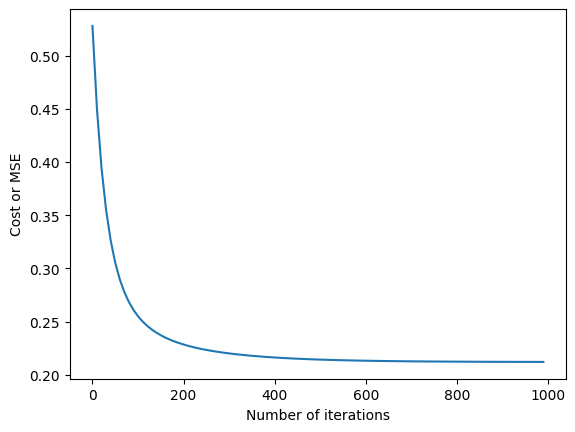

In [177]:
# zobrazení historie učení
fig2=plt.figure()
plt.plot(gd_iterations_df['iteration'], gd_iterations_df['cost'])
plt.xlabel("Number of iterations")
plt.ylabel("Cost or MSE")

# Linearní modelu pomocí scikit-learn
- Vytvořte si ručně model lineární regrese bez pomoci externích knihoven
- Vypište jeho parametry
- Vypiše jeho skóre pro trénovací a validační data
- Vykreslete graf historie učení
- Vizualizujte model

In [ ]:
from sklearn.linear_model import LinearRegression

In [181]:
# vytvoření linearního modelu
lin_model = LinearRegression()

In [182]:
# trénování modelu na tréninkových datech
lin_model.fit(X_train, Y_train)

LinearRegression()

In [183]:
print ("Bias: ", lin_model.intercept_)
print("Weights: ", lin_model.coef_)

Bias:  0.00336591797801854
Weights:  [0.5409631  0.25858517 0.14357655 0.25715613]


In [184]:
# predikce hodnot
Y_predicted = lin_model.predict(X_train)

In [185]:
print_model_score(Y_train, Y_predicted)

R2 score: 0.6111196723802943
RMSE: 0.6512680596107953


In [186]:
visualize_model_3D(X1, X2, Y_train, lin_model.intercept_, lin_model.coef_, 40)

In [187]:
Y_val_predict = lin_model.predict(X_val)

In [188]:
print_model_score(Y_val, Y_val_predict)


R2 score: 0.5352797476584255
RMSE: 0.5977344684451907
